# Analiza danych tekstowych, porównanie technik obróbki tekstu w kontekście klasyfikacji

Wykonanie analizy oraz stworzenie modeli klasyfikacji tekstu w kontekście analizy sentymentu na podstawie danych z Twittera dotyczących COVID-19. Wykorzystanie różnych technik przetwarzania tekstu oraz porównanie ich skuteczności w klasyfikacji sentymentu.

## Wczytanie danych

In [4]:
import pandas as pd

df_train = pd.read_csv("../data/Corona_NLP_train.csv", encoding="latin-1")
df_test = pd.read_csv("../data/Corona_NLP_test.csv")

In [5]:
print(f"== DF TRAIN I TEST COLUMNS ==")
print(f"train: {df_train.columns.to_list()},\ntest: {df_test.columns.to_list()}\n")
print(f"== DF TRAIN I TEST SHAPE ==")
print(f"train: {df_train.shape},\ntest: {df_test.shape}")

== DF TRAIN I TEST COLUMNS ==
train: ['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet', 'Sentiment'],
test: ['UserName', 'ScreenName', 'Location', 'TweetAt', 'OriginalTweet', 'Sentiment']

== DF TRAIN I TEST SHAPE ==
train: (41157, 6),
test: (3798, 6)


In [6]:
df = pd.concat([df_train, df_test])
print(f"== DF SHAPE ==\n {df.shape}")

== DF SHAPE ==
 (44955, 6)


In [7]:
print("== HEAD DF ==")
print(df.head())

== HEAD DF ==
   UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative  


Mamy wiele kolumn, które nie będą nam potrzebne podczas analizy tekstu i klasyfikacji sentymentu, stąd usuwamy je.

In [8]:
df = df.drop(columns=["UserName", "ScreenName", "Location", "TweetAt"], axis=1)

Poniżej widzimy, że mamy 5 kategorii w kolumnie `Sentiment`. Wartości te są następujące:

Text(0, 0.5, 'Count')

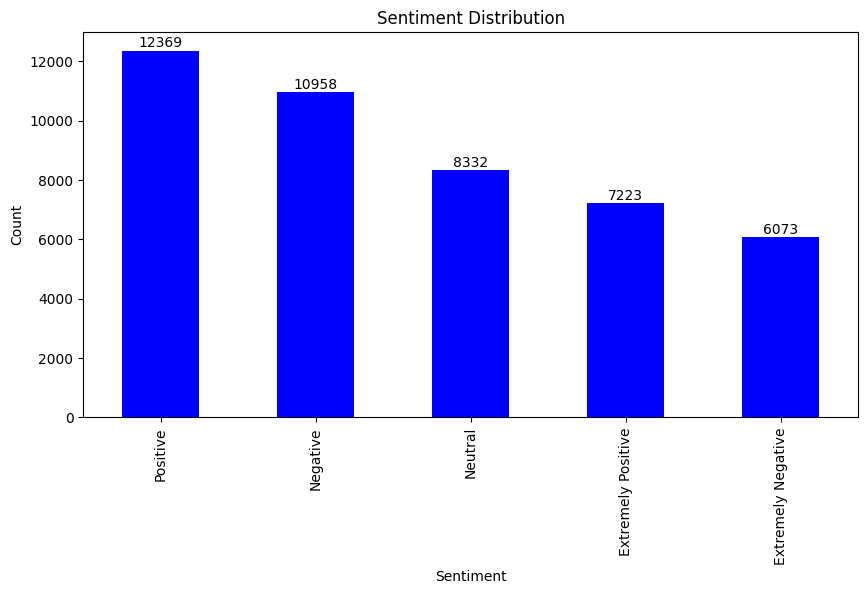

In [9]:
import matplotlib.pyplot as plt

data = df['Sentiment'].value_counts()

plt.plot()
data.plot(kind='bar', color='blue', figsize=(10, 5))
for i, v in enumerate(data):
    plt.text(i, v + 10, str(v), ha='center', va='bottom', fontsize=10)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')


Utworzymy także bardziej zagęszczone klasy, gdyż złączymy Extremely Positive z Positive oraz Extremely Negative z Negative - stworzymy nową kolumnę `CondensedSentiment`

Text(0, 0.5, 'Count')

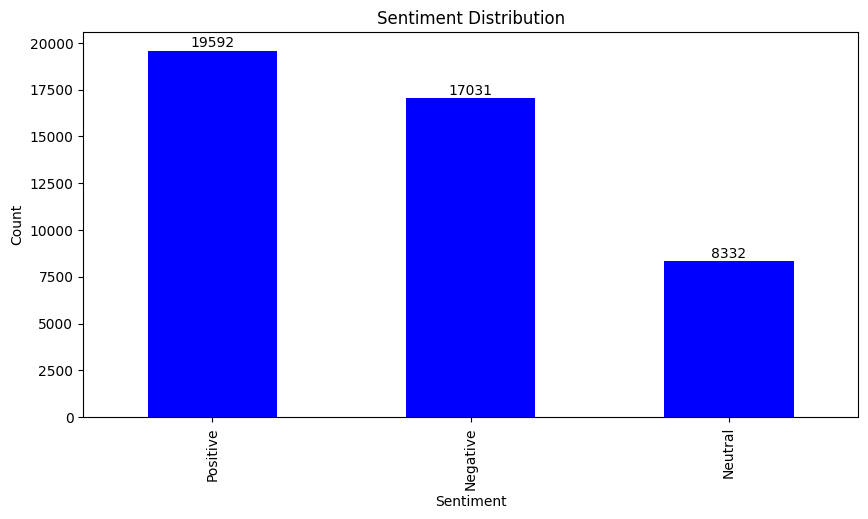

In [10]:
mappings = {
    "Extremely Negative": "Negative",
    "Extremely Positive": "Positive",
    "Negative": "Negative",
    "Neutral": "Neutral",
    "Positive": "Positive"
}

df['CondensedSentiment'] = df['Sentiment'].map(mappings)
data = df['CondensedSentiment'].value_counts() 
plt.plot()
data.plot(kind='bar', color='blue', figsize=(10, 5))
for i, v in enumerate(data):
    plt.text(i, v + 10, str(v), ha='center', va='bottom', fontsize=10)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')

## Preprocesowanie danych

In [11]:
lst = df['OriginalTweet'][:3].tolist()
for l in lst:
    print(f"{l}\n")

@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/iFz9FAn2Pa and https://t.co/xX6ghGFzCC and https://t.co/I2NlzdxNo8

advice Talk to your neighbours family to exchange phone numbers create contact list with phone numbers of neighbours schools employer chemist GP set up online shopping accounts if poss adequate supplies of regular meds but not over order

Coronavirus Australia: Woolworths to give elderly, disabled dedicated shopping hours amid COVID-19 outbreak https://t.co/bInCA9Vp8P



### Sprowadzenie tesktu do małych liter

In [12]:
print(f"== BEFORE LOWER ==\n{df['OriginalTweet'][:3]}\n")
df['ProcessedTweet'] = df['OriginalTweet'].str.lower()
print(f"== AFTER LOWER ==\n{df['ProcessedTweet'][:3]}\n")

== BEFORE LOWER ==
0    @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...
1    advice Talk to your neighbours family to excha...
2    Coronavirus Australia: Woolworths to give elde...
Name: OriginalTweet, dtype: object

== AFTER LOWER ==
0    @menyrbie @phil_gahan @chrisitv https://t.co/i...
1    advice talk to your neighbours family to excha...
2    coronavirus australia: woolworths to give elde...
Name: ProcessedTweet, dtype: object



### Usunięcie oznaczeń użytkowników oraz linków do stron internetowych

Zbiór danych zawiera tweety, które jak widzimy, zawierają linki oraz oznaczenia użytkowników (@uzytkownik1, @uzytkownik2). W tej sekcji usuniemy te oznaczenia oraz linki.

In [13]:
def remove_usernames_and_links(text):
    text = ' '.join([word for word in text.split() if not word.startswith('@')])
    text = ' '.join([word for word in text.split() if not word.startswith('http')])
    return text

In [14]:
print(f"== BEFORE USERNAMES AND LINKS ==\n{df['ProcessedTweet'][:3]}\n")
df['ProcessedTweet'] = df['ProcessedTweet'].apply(remove_usernames_and_links)
print(f"== AFTER USERNAMES AND LINKS ==\n{df['ProcessedTweet'][:3]}\n")

== BEFORE USERNAMES AND LINKS ==
0    @menyrbie @phil_gahan @chrisitv https://t.co/i...
1    advice talk to your neighbours family to excha...
2    coronavirus australia: woolworths to give elde...
Name: ProcessedTweet, dtype: object

== AFTER USERNAMES AND LINKS ==
0                                              and and
1    advice talk to your neighbours family to excha...
2    coronavirus australia: woolworths to give elde...
Name: ProcessedTweet, dtype: object



### Usunięcie słów stopu

In [15]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
from nltk.corpus import stopwords
stop_words = list(stopwords.words('english'))

In [17]:
print(f"== ENGLISH STOPWORDS ==\n{len(stop_words)}\n{stop_words[:10]}\n")

== ENGLISH STOPWORDS ==
198
['a', 'about', 'above', 'after', 'again', 'against', 'ain', 'all', 'am', 'an']



In [18]:
print(f"== BEFORE STOPWORDS ==\n{df['ProcessedTweet'][:3]}\n")
df['ProcessedTweet'] = df['ProcessedTweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
print(f"== AFTER STOPWORDS ==\n{df['ProcessedTweet'][:3]}\n")

== BEFORE STOPWORDS ==
0                                              and and
1    advice talk to your neighbours family to excha...
2    coronavirus australia: woolworths to give elde...
Name: ProcessedTweet, dtype: object

== AFTER STOPWORDS ==
0                                                     
1    advice talk neighbours family exchange phone n...
2    coronavirus australia: woolworths give elderly...
Name: ProcessedTweet, dtype: object



Widzimy, że pierwszy tekst został usunięty w całości stąd będzie trzeba sprawdzić jak wiele postów zostanie wyczyszczonych w ten sposób.

### Usunięcie znaków interpunkcyjnych i cyfr

In [19]:
import re

def remove_numbers(text):
    result = re.sub(r'\d+', '', text)
    return result

def remove_punctuation(text):
    result = re.sub(r'[^\w\s]', '', text)
    return result

In [20]:
print(f"== BEFORE NUMBERS AND PUNCTUATION ==\n{df['ProcessedTweet'][:3]}\n")
df['ProcessedTweet'] = df['ProcessedTweet'].apply(remove_numbers)
df['ProcessedTweet'] = df['ProcessedTweet'].apply(remove_punctuation)
print(f"== AFTER NUMBERS AND PUNCTUATION ==\n{df['ProcessedTweet'][:3]}\n")

== BEFORE NUMBERS AND PUNCTUATION ==
0                                                     
1    advice talk neighbours family exchange phone n...
2    coronavirus australia: woolworths give elderly...
Name: ProcessedTweet, dtype: object

== AFTER NUMBERS AND PUNCTUATION ==
0                                                     
1    advice talk neighbours family exchange phone n...
2    coronavirus australia woolworths give elderly ...
Name: ProcessedTweet, dtype: object



### Lematyzacja

Jest to proces sprowadzania słów do ich podstawowych form. Do tego celu możemy wykorzystać dwie biblioteki - NLTK oraz SpaCy. 

In [21]:
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
!python -m spacy download en_core_web_sm
import spacy
nlp = spacy.load('en_core_web_sm')

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --- ------------------------------------ 1.0/12.8 MB 10.1 MB/s eta 0:00:02
     ----------------------- ---------------- 7.6/12.8 MB 24.7 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 32.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [23]:
print(f"== BEFORE LEMMATIZATION ==\n{df['ProcessedTweet'][:3]}\n")
df['NLTKProcessed'] = df['ProcessedTweet'].apply(lambda x: ' '.join([lemmatizer.lemmatize(word) for word in x.split()]))
df['SpacyProcessed'] = df['ProcessedTweet'].apply(lambda x: ' '.join([token.lemma_ for token in nlp(x)]))
print(f"== AFTER LEMMATIZATION (NLTK)==\n{df['NLTKProcessed'][:3]}\n")
print(f"== AFTER LEMMATIZATION (SPACY)==\n{df['SpacyProcessed'][:3]}\n")

== BEFORE LEMMATIZATION ==
0                                                     
1    advice talk neighbours family exchange phone n...
2    coronavirus australia woolworths give elderly ...
Name: ProcessedTweet, dtype: object

== AFTER LEMMATIZATION (NLTK)==
0                                                     
1    advice talk neighbour family exchange phone nu...
2    coronavirus australia woolworth give elderly d...
Name: NLTKProcessed, dtype: object

== AFTER LEMMATIZATION (SPACY)==
0                                                     
1    advice talk neighbour family exchange phone nu...
2    coronavirus australia woolworth give elderly d...
Name: SpacyProcessed, dtype: object



Możemy także sprawdzić jak różnią się od siebie oba zbiory. 

In [24]:
df.columns

Index(['OriginalTweet', 'Sentiment', 'CondensedSentiment', 'ProcessedTweet',
       'NLTKProcessed', 'SpacyProcessed'],
      dtype='object')

In [25]:
differences = df[df['NLTKProcessed'] != df['SpacyProcessed']]
print(f"== DIFFERENT RECORDS ==\nLiczba różniących się wierszy: {len(differences)}, wszystkich jest: {len(df)}\n")

== DIFFERENT RECORDS ==
Liczba różniących się wierszy: 41132, wszystkich jest: 44955



In [26]:
def compare_words(nltk_text, spacy_text):
    nltk_words = set(nltk_text.split())
    spacy_words = set(spacy_text.split())
    return {
        'only_in_nltk': nltk_words - spacy_words,
        'only_in_spacy': spacy_words - nltk_words
    }

nltk_words = set(' '.join(df['NLTKProcessed']).split())
spacy_words = set(' '.join(df['SpacyProcessed']).split())

only_in_nltk = nltk_words - spacy_words
only_in_spacy = spacy_words - nltk_words

total_unique_words = len(nltk_words.union(spacy_words))
different_words = len(only_in_nltk) + len(only_in_spacy)
percentage_difference = (different_words / total_unique_words) * 100

print(f"Liczba unikalnych słów w NLTK: {len(nltk_words)}")
print(f"Liczba unikalnych słów w SpaCy: {len(spacy_words)}")
print(f"Liczba słów różniących się między NLTK i SpaCy: {different_words}")
print(f"Procent różnic na poziomie słów: {percentage_difference:.2f}%")

Liczba unikalnych słów w NLTK: 49503
Liczba unikalnych słów w SpaCy: 47362
Liczba słów różniących się między NLTK i SpaCy: 13529
Procent różnic na poziomie słów: 24.51%


Widzimy, że na zbiorze niemalże 45000 rekordów oba lematyzatory różnią się od siebie w sposobie sprowadzania słów do podstawowej postaci. Stąd też wytrenowane modele będziemy weryfikować uwzględniając, który lematyzator został użyty.

### Stematyzacja

Stemming to proces obcinania końcówek słów sprowadzając je do rdzenia. Nie bierze przy tym pod uwagę, czy takie słowo istnieje czy też nie. Tym właśnie różni się od lematyzacji, która sprowadza do podstawowej formy, ale to słowo jest w słowniku. 

In [27]:
from nltk.stem import PorterStemmer 
stemmer = PorterStemmer()

In [28]:
print(f"== BEFORE STEMMING ==\n{df['ProcessedTweet'][:3]}\n")
df['Stemmed'] = df['ProcessedTweet'].apply(lambda x: ' '.join([stemmer.stem(word) for word in x.split()]))
print(f"== AFTER STEMMING ==\n{df['Stemmed'][:3]}\n")

== BEFORE STEMMING ==
0                                                     
1    advice talk neighbours family exchange phone n...
2    coronavirus australia woolworths give elderly ...
Name: ProcessedTweet, dtype: object

== AFTER STEMMING ==
0                                                     
1    advic talk neighbour famili exchang phone numb...
2    coronaviru australia woolworth give elderli di...
Name: Stemmed, dtype: object



## Modele ML

### Przygotowanie danych do modeli

In [29]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import time

In [30]:
# accuracy, precision, recall, f1-score
eval_metrics = {
    'NLTK': {
        'Naive Bayes': {},
        'SVM': {},
        'Random Forest': {},
        'Logistic Regression': {},
        'BERT': {}
    }, 
    'SpaCy': {
        'Naive Bayes': {},
        'SVM': {},
        'Random Forest': {},
        'Logistic Regression': {},
        'BERT': {}
    },
    'Stemmed': {
        'Naive Bayes': {},
        'SVM': {},
        'Random Forest': {},
        'Logistic Regression': {},
        'BERT': {}
    },
    'Processed': {
        'Naive Bayes': {},
        'SVM': {},
        'Random Forest': {},
        'Logistic Regression': {},
        'BERT': {}
    },
    'Original': {
        'Naive Bayes': {},
        'SVM': {},
        'Random Forest': {},
        'Logistic Regression': {},
        'BERT': {}
    }
}

In [31]:
print(list(df.columns))

texts_nltk = df['NLTKProcessed'].tolist()           # użyto NLTK do lematyzacji
texts_spacy = df['SpacyProcessed'].tolist()         # użyto Spacy do lematyzacji
texts_stemmed = df['Stemmed'].tolist()              # użyto stemmingu
texts_processed = df['ProcessedTweet'].tolist()     # użyto przetworzonego tekstu bez lematyzacji i stemmingu
texts = df['OriginalTweet'].tolist()                # użyto oryginalnego tekstu
labels_5_class = df['Sentiment'].tolist()
labels_3_class = df['CondensedSentiment'].tolist()

['OriginalTweet', 'Sentiment', 'CondensedSentiment', 'ProcessedTweet', 'NLTKProcessed', 'SpacyProcessed', 'Stemmed']


In [32]:
vectorizer = TfidfVectorizer(max_features=5000)  # np. do 5000 słów
X_nltk = vectorizer.fit_transform(texts_nltk)
X_spacy = vectorizer.fit_transform(texts_spacy)
X_stemmed = vectorizer.fit_transform(texts_stemmed)
X_processed = vectorizer.fit_transform(texts_processed)
X = vectorizer.fit_transform(texts)
y_5 = labels_5_class
y_3 = labels_3_class

In [34]:
X_train_nltk, X_test_nltk, y_train_5_nltk, y_test_5_nltk = train_test_split(X_nltk, y_5, test_size=0.25, random_state=42)
X_train_spacy, X_test_spacy, y_train_5_spacy, y_test_5_spacy = train_test_split(X_spacy, y_5, test_size=0.25, random_state=42)
X_train_stemmed, X_test_stemmed, y_train_5_stemmed, y_test_5_stemmed = train_test_split(X_stemmed, y_5, test_size=0.25, random_state=42)
X_train_processed, X_test_processed, y_train_5_processed, y_test_5_processed = train_test_split(X_processed, y_5, test_size=0.25, random_state=42)
X_train, X_test, y_train_5, y_test_5 = train_test_split(X, y_5, test_size=0.25, random_state=42)

X_train_nltk_3, X_test_nltk_3, y_train_3_nltk, y_test_3_nltk = train_test_split(X_nltk, y_3, test_size=0.25, random_state=42)
X_train_spacy_3, X_test_spacy_3, y_train_3_spacy, y_test_3_spacy = train_test_split(X_spacy, y_3, test_size=0.25, random_state=42)
X_train_stemmed_3, X_test_stemmed_3, y_train_3_stemmed, y_test_3_stemmed = train_test_split(X_stemmed, y_3, test_size=0.25, random_state=42)
X_train_processed_3, X_test_processed_3, y_train_3_processed, y_test_3_processed = train_test_split(X_processed, y_3, test_size=0.25, random_state=42)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, y_3, test_size=0.25, random_state=42)

X_trains = {
    'NLTK': (X_train_nltk, X_train_nltk_3),
    'SpaCy': (X_train_spacy, X_train_spacy_3),
    'Stemmed': (X_train_stemmed, X_train_stemmed_3),
    'Processed': (X_train_processed, X_train_processed_3),
    'Original': (X_train, X_train_3)
}
X_tests = {
    'NLTK': (X_test_nltk, X_test_nltk_3),
    'SpaCy': (X_test_spacy, X_test_spacy_3),
    'Stemmed': (X_test_stemmed, X_test_stemmed_3),
    'Processed': (X_test_processed, X_test_processed_3),
    'Original': (X_test, X_test_3)
}
y_trains = {
    'NLTK': (y_train_5_nltk, y_train_3_nltk),
    'SpaCy': (y_train_5_spacy, y_train_3_spacy),
    'Stemmed': (y_train_5_stemmed, y_train_3_stemmed),
    'Processed': (y_train_5_processed, y_train_3_processed),
    'Original': (y_train_5, y_train_3)
}
y_tests = {
    'NLTK': (y_test_5_nltk, y_test_3_nltk),
    'SpaCy': (y_test_5_spacy, y_test_3_spacy),
    'Stemmed': (y_test_5_stemmed, y_test_3_stemmed),
    'Processed': (y_test_5_processed, y_test_3_processed),
    'Original': (y_test_5, y_test_3)
}

In [35]:
mappings = {
    0: '5 class',
    1: '3 class'
}

### Naive Bayes

In [37]:
for i in range(1, 2):
    for key, value in X_trains.items():
        X_train, y_train = X_trains[key][i], y_trains[key][i]
        X_test, y_test = X_tests[key][i], y_tests[key][i]
        
        start_time = time.time()
        
        clf = MultinomialNB()
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        print(f"=== NAIVE BAYES {key} - {mappings.get(i)} ===\naccuracy: {accuracy}, precision: {precision}, recall: {recall}, f1-score: {f1}\n")

        # zapisanie metryk do przygotowanego słownika
        eval_metrics[key]['Naive Bayes'][str(mappings.get(i))] = {      
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1-score': f1,
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'elapsed_time': elapsed_time
        }

=== NAIVE BAYES NLTK - 3 class ===
accuracy: 0.673992348073672, precision: 0.6792170107743909, recall: 0.673992348073672, f1-score: 0.6434197055529789

=== NAIVE BAYES SpaCy - 3 class ===
accuracy: 0.6708781920099653, precision: 0.6753175983887862, recall: 0.6708781920099653, f1-score: 0.6386831864716054

=== NAIVE BAYES Stemmed - 3 class ===
accuracy: 0.6689207224842068, precision: 0.6717929213841709, recall: 0.6689207224842068, f1-score: 0.6360876728544459

=== NAIVE BAYES Processed - 3 class ===
accuracy: 0.6731915650858618, precision: 0.6780879707721666, recall: 0.6731915650858618, f1-score: 0.6424478420271835

=== NAIVE BAYES Original - 3 class ===
accuracy: 0.6766616246997064, precision: 0.6841042102545094, recall: 0.6766616246997064, f1-score: 0.6478581830941134



### SVM

In [38]:
for i in range(1, 2):
    for key, value in X_trains.items():
        X_train, y_train = X_trains[key][i], y_trains[key][i]
        X_test, y_test = X_tests[key][i], y_tests[key][i]
        
        start_time = time.time()
        
        svc = SVC()
        svc.fit(X_train, y_train)
        y_pred = svc.predict(X_test)
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        print(f"=== SVM {key} - {mappings.get(i)} ===\naccuracy: {accuracy}, precision: {precision}, recall: {recall}, f1-score: {f1}\n")

        # zapisanie metryk do przygotowanego słownika
        eval_metrics[key]['SVM'][str(mappings.get(i))] = {      
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1-score': f1,
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'elapsed_time': elapsed_time
        }

=== SVM NLTK - 3 class ===
accuracy: 0.7811193166651837, precision: 0.7788483177426098, recall: 0.7811193166651837, f1-score: 0.7785300390665959

=== SVM SpaCy - 3 class ===
accuracy: 0.7851232316042352, precision: 0.7830582057970165, recall: 0.7851232316042352, f1-score: 0.7827832421619683

=== SVM Stemmed - 3 class ===
accuracy: 0.7814752202153217, precision: 0.7793230261790961, recall: 0.7814752202153217, f1-score: 0.7787337883789133

=== SVM Processed - 3 class ===
accuracy: 0.7837885932912181, precision: 0.781578595225334, recall: 0.7837885932912181, f1-score: 0.7812257202225037

=== SVM Original - 3 class ===
accuracy: 0.7950885310080968, precision: 0.7934694035162213, recall: 0.7950885310080968, f1-score: 0.7930609767662058



### Random Forest

In [39]:
for i in range(1, 2):
    for key, value in X_trains.items():
        X_train, y_train = X_trains[key][i], y_trains[key][i]
        X_test, y_test = X_tests[key][i], y_tests[key][i]
        
        start_time = time.time()
        
        rfc = RandomForestClassifier()
        rfc.fit(X_train, y_train)
        y_pred = rfc.predict(X_test)
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        print(f"=== RANDOM FOREST {key} - {mappings.get(i)} ===\naccuracy: {accuracy}, precision: {precision}, recall: {recall}, f1-score: {f1}\n")

        # zapisanie metryk do przygotowanego słownika
        eval_metrics[key]['Random Forest'][str(mappings.get(i))] = {      
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1-score': f1,
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'elapsed_time': elapsed_time
        }

=== RANDOM FOREST NLTK - 3 class ===
accuracy: 0.7248865557433936, precision: 0.7239728149868242, recall: 0.7248865557433936, f1-score: 0.7243590091742833

=== RANDOM FOREST SpaCy - 3 class ===
accuracy: 0.7308479402082035, precision: 0.7295696627054918, recall: 0.7308479402082035, f1-score: 0.7299765381747868

=== RANDOM FOREST Stemmed - 3 class ===
accuracy: 0.735207758697393, precision: 0.7337495668495018, recall: 0.735207758697393, f1-score: 0.734170352911134

=== RANDOM FOREST Processed - 3 class ===
accuracy: 0.7197259542663939, precision: 0.7193252210818242, recall: 0.7197259542663939, f1-score: 0.7195085378206036

=== RANDOM FOREST Original - 3 class ===
accuracy: 0.692410356793309, precision: 0.691079824526346, recall: 0.692410356793309, f1-score: 0.6875306412533092



### Logistic Regression

In [40]:
for i in range(1, 2):
    for key, value in X_trains.items():
        X_train, y_train = X_trains[key][i], y_trains[key][i]
        X_test, y_test = X_tests[key][i], y_tests[key][i]
        
        start_time = time.time()
        
        lr = LogisticRegression()
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        
        end_time = time.time()
        elapsed_time = end_time - start_time
        
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')
        print(f"=== LOGISTIC REGRESSION {key} - {mappings.get(i)} ===\naccuracy: {accuracy}, precision: {precision}, recall: {recall}, f1-score: {f1}\n")

        # zapisanie metryk do przygotowanego słownika
        eval_metrics[key]['Logistic Regression'][str(mappings.get(i))] = {      
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1-score': f1,
            'confusion_matrix': confusion_matrix(y_test, y_pred),
            'elapsed_time': elapsed_time
        }

=== LOGISTIC REGRESSION NLTK - 3 class ===
accuracy: 0.7932200373698728, precision: 0.7911708465832191, recall: 0.7932200373698728, f1-score: 0.7912034421640398

=== LOGISTIC REGRESSION SpaCy - 3 class ===
accuracy: 0.7916184713942521, precision: 0.7894653421082665, recall: 0.7916184713942521, f1-score: 0.7897468140453674



d:\STUDIA\STUDIA II ST\II SEM\Współczesne Technologie Analizy Danych\projekt\text-classification-analysis\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== LOGISTIC REGRESSION Stemmed - 3 class ===
accuracy: 0.7880594358928731, precision: 0.7859810557946417, recall: 0.7880594358928731, f1-score: 0.7860658290240188



d:\STUDIA\STUDIA II ST\II SEM\Współczesne Technologie Analizy Danych\projekt\text-classification-analysis\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


=== LOGISTIC REGRESSION Processed - 3 class ===
accuracy: 0.7905507607438385, precision: 0.7884238121518032, recall: 0.7905507607438385, f1-score: 0.7887394456464555

=== LOGISTIC REGRESSION Original - 3 class ===
accuracy: 0.8026514814485275, precision: 0.8010694324471362, recall: 0.8026514814485275, f1-score: 0.8011141212644012



d:\STUDIA\STUDIA II ST\II SEM\Współczesne Technologie Analizy Danych\projekt\text-classification-analysis\myenv\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


### BERT

# Metryki wszystkich modeli

## Wyświetlenie metryk

In [44]:
import numpy as np

for key, value in eval_metrics.items():
    for key2, value2 in value.items():
        for key3, value3 in value2.items():
            print(f"=== {key} - {key2} - {key3} ===")
            print(f"accuracy: {value3['accuracy']}")
            print(f"precision: {value3['precision']}")
            print(f"recall: {value3['recall']}")
            print(f"f1-score: {value3['f1-score']}")
            
            # Zamiana confusion_matrix na listę
            if isinstance(value3['confusion_matrix'], np.ndarray):
                value3['confusion_matrix'] = value3['confusion_matrix'].tolist()
            
            print(f"confusion_matrix: \n{value3['confusion_matrix']}")
            print(f"elapsed_time: {value3['elapsed_time']}\n")

=== NLTK - Naive Bayes - 3 class ===
accuracy: 0.673992348073672
precision: 0.6792170107743909
recall: 0.673992348073672
f1-score: 0.6434197055529789
confusion_matrix: 
[[3071, 87, 1078], [616, 382, 1097], [707, 79, 4122]]
elapsed_time: 0.03590583801269531

=== NLTK - SVM - 3 class ===
accuracy: 0.7811193166651837
precision: 0.7788483177426098
recall: 0.7811193166651837
f1-score: 0.7785300390665959
confusion_matrix: 
[[3365, 248, 623], [434, 1255, 406], [525, 224, 4159]]
elapsed_time: 302.24549674987793

=== NLTK - Random Forest - 3 class ===
accuracy: 0.7248865557433936
precision: 0.7239728149868242
recall: 0.7248865557433936
f1-score: 0.7243590091742833
confusion_matrix: 
[[3066, 372, 798], [418, 1276, 401], [730, 373, 3805]]
elapsed_time: 39.337860345840454

=== NLTK - Logistic Regression - 3 class ===
accuracy: 0.7932200373698728
precision: 0.7911708465832191
recall: 0.7932200373698728
f1-score: 0.7912034421640398
confusion_matrix: 
[[3416, 237, 583], [388, 1314, 393], [479, 244, 4

## Zapisanie metryk do pliku

In [45]:
import json 

with open('eval_metrics.json', 'w') as f:
    json.dump(eval_metrics, f)

# Omówienie wyników modeli

In [ ]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

2.3.1+cu118
True


device(type='cuda', index=0)